<a href="https://colab.research.google.com/github/Matheus-Homem/international_bank_marketing/blob/main/notebooks/c3_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

## 0.1. Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn import preprocessing as pp
from sklearn import metrics as m
from plotly import express as px
import umap.umap_ as umap
from IPython.display import HTML

## 0.2. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3. Load Dataset

In [4]:
df = pd.read_csv('../data/CC GENERAL.csv')

In [5]:
df.sample().T

,867
CUST_ID,C10898
BALANCE,1254.970145
BALANCE_FREQUENCY,1.0
PURCHASES,769.34
ONEOFF_PURCHASES,769.34
INSTALLMENTS_PURCHASES,0.0
CASH_ADVANCE,2234.780695
PURCHASES_FREQUENCY,0.166667
ONEOFF_PURCHASES_FREQUENCY,0.166667
PURCHASES_INSTALLMENTS_FREQUENCY,0.0


# 1. Data Description

In [6]:
df1 = df.copy()

## 1.1. Rename Columns

In [7]:
df1.columns = list(map(lambda x: x.lower(), df1.columns))

## 1.2. Data Dimensions

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 8950
Number of columns: 18


## 1.3. Data Types

In [9]:
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

## 1.5. Replace NA

In [11]:
# Replacing credit_limit variable
df1['credit_limit'].fillna(df1['credit_limit'].min(),inplace=True)

# Replacing minimum_payments variable
df1['minimum_payments'].fillna(0,inplace=True)

## 1.6. Change dtypes

In [12]:
df1['cust_id'] = df1['cust_id'].map(lambda x: x[1:]).astype(int)

## 1.7. Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [14]:
# Central Tendency -> Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion -> Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
metrics = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
metrics.columns = ['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']
metrics

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,balance,0.0,19043.13856,19043.13856,1564.474828,873.385231,2081.415590,2.393386,7.674751
1,balance_frequency,0.0,1.00000,1.00000,0.877271,1.000000,0.236891,-2.023266,3.092370
2,purchases,0.0,49039.57000,49039.57000,1003.204834,361.280000,2136.515413,8.144269,111.388771
3,oneoff_purchases,0.0,40761.25000,40761.25000,592.437371,38.000000,1659.795184,10.045083,164.187572
4,installments_purchases,0.0,22500.00000,22500.00000,411.067645,89.000000,904.287592,7.299120,96.575178
5,cash_advance,0.0,47137.21176,47137.21176,978.871112,0.000000,2097.046713,5.166609,52.899434
6,purchases_frequency,0.0,1.00000,1.00000,0.490351,0.500000,0.401348,0.060164,-1.638631
7,oneoff_purchases_frequency,0.0,1.00000,1.00000,0.202458,0.083333,0.298319,1.535613,1.161846
8,purchases_installments_frequency,0.0,1.00000,1.00000,0.364437,0.166667,0.397426,0.509201,-1.398632
9,cash_advance_frequency,0.0,1.50000,1.50000,0.135144,0.000000,0.200110,1.828686,3.334734


# 2. Feature Filtering

In [15]:
df2 = df1.copy()

In [16]:
# Filtering three lines that put number of transactions equal to 0 and transaction value different from 0
df2 = df2[~((df1['purchases_trx']==0) & (df1['purchases']!=0))]

# 3. Feature Engineering

In [17]:
df3 = df2.copy()

## 3.1. Feature Creation

In [18]:
df3.sample(5).T

,5083,3618,3901,6201,2734
cust_id,15226.000000,13721.000000,14011.000000,16374.000000,12812.000000
balance,1908.569743,150.351606,580.175457,44.444599,141.781912
balance_frequency,1.000000,1.000000,1.000000,1.000000,0.545455
purchases,0.000000,352.920000,759.500000,374.810000,1401.400000
oneoff_purchases,0.000000,352.920000,85.000000,0.000000,0.000000
installments_purchases,0.000000,0.000000,674.500000,374.810000,1401.400000
cash_advance,4604.425401,0.000000,995.015703,0.000000,0.000000
purchases_frequency,0.000000,0.333333,0.833333,0.416667,1.000000
oneoff_purchases_frequency,0.000000,0.333333,0.166667,0.000000,0.000000
purchases_installments_frequency,0.000000,0.000000,0.750000,0.333333,1.000000


In [19]:
df_ref = df3[['cust_id',
              'oneoff_purchases',
              'installments_purchases',
              'oneoff_purchases_frequency',
              'purchases_installments_frequency',
              'purchases_trx']].copy()

df_ref.sample(5).T

,7735,4470,6776,5624,6584
cust_id,17944.00,14594.000000,16964.000000,15781.00,16765.0
oneoff_purchases,0.00,169.200000,107.000000,0.00,0.0
installments_purchases,220.06,952.660000,0.000000,539.88,0.0
oneoff_purchases_frequency,0.00,0.083333,0.083333,0.00,0.0
purchases_installments_frequency,1.00,0.583333,0.000000,1.00,0.0
purchases_trx,12.00,11.000000,1.000000,14.00,0.0


# 4. EDA (Exploratory Data Analysis)

In [20]:
df4 = df_ref.copy()

## 4.1. Univariate Analysis

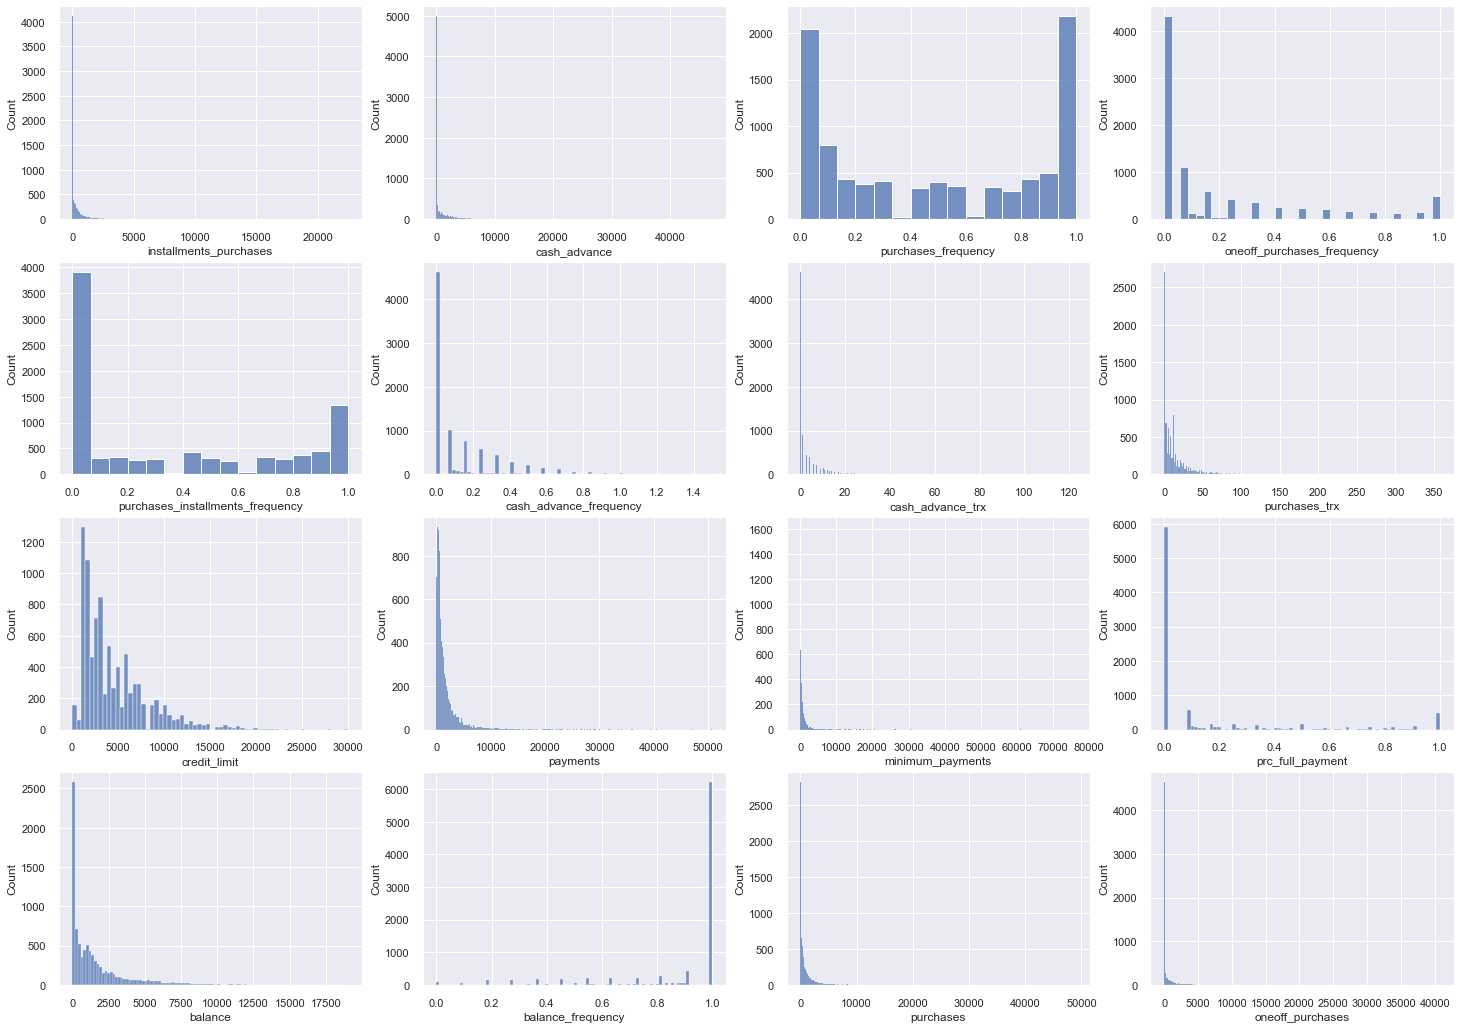

In [21]:
fig, ax = plt.subplots(4,4,figsize=(25,18))
features = num_attributes.drop('tenure',axis=1).columns
for k in range(16):
  q, mod = divmod(k,4)
  sns.histplot(data=df1,x=features[k],ax=ax[q-1][mod])

# 5. Data Preparation

In [22]:
df5 = df4.copy()

In [23]:
df5.head()

,cust_id,oneoff_purchases,installments_purchases,oneoff_purchases_frequency,purchases_installments_frequency,purchases_trx
0,10001,0.00,95.4,0.000000,0.083333,2
1,10002,0.00,0.0,0.000000,0.000000,0
2,10003,773.17,0.0,1.000000,0.000000,12
3,10004,1499.00,0.0,0.083333,0.000000,1
4,10005,16.00,0.0,0.083333,0.000000,1


In [24]:
## Standard Scaler
ss = pp.StandardScaler()

df5['oneoff_purchases_frequency'] = ss.fit_transform(df5[['oneoff_purchases_frequency']])
df5['oneoff_purchases'] = ss.fit_transform(df5[['oneoff_purchases']])
df5['installments_purchases'] = ss.fit_transform(df5[['installments_purchases']])
df5['purchases_trx'] = ss.fit_transform(df5[['purchases_trx']])
df5['purchases_installments_frequency'] = ss.fit_transform(df5[['purchases_installments_frequency']])

# 6. Feature Selection

In [25]:
df6 = df5.copy()

# 7. Hyperparameter Fine-Tunning

In [26]:
X = df6.drop('cust_id',axis=1)

In [27]:
clusters = [2,3,4,5,6,7,8,9]

In [28]:
model = KMeans(random_state=101)

## 7.1. Within-Cluster Sum of Square (WSS)

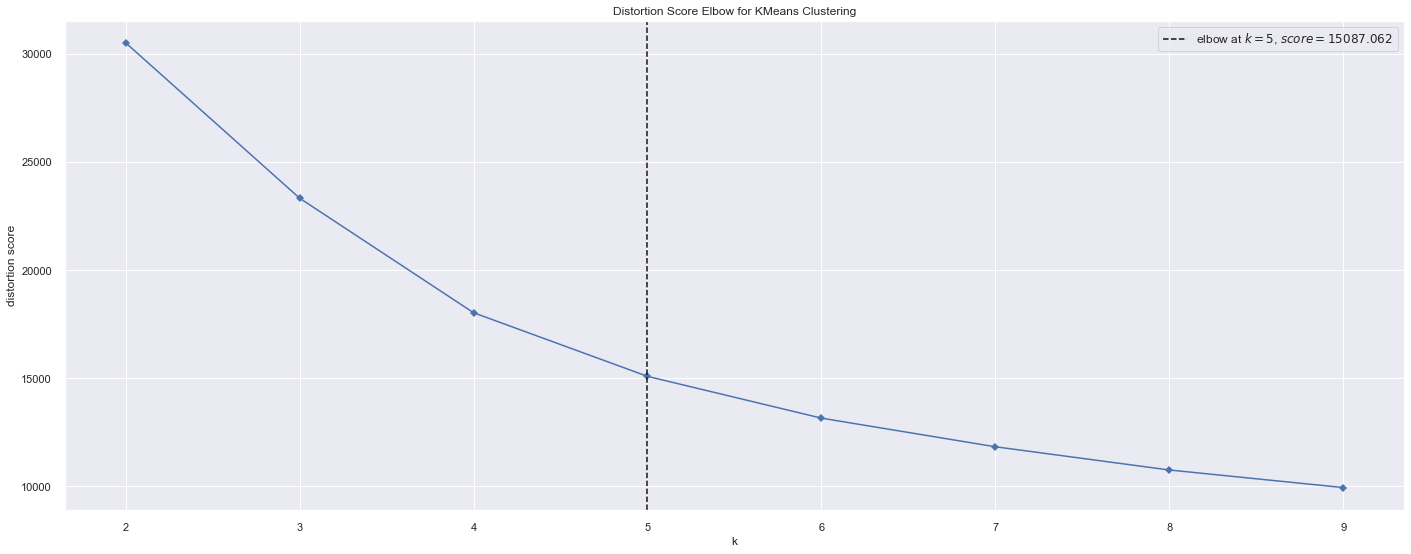

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
kmeans = KElbowVisualizer(model,k=clusters, metric='distortion',timings=False,random_state=101)
kmeans.fit(X)
kmeans.show()

## 7.2. Sillhouette Score

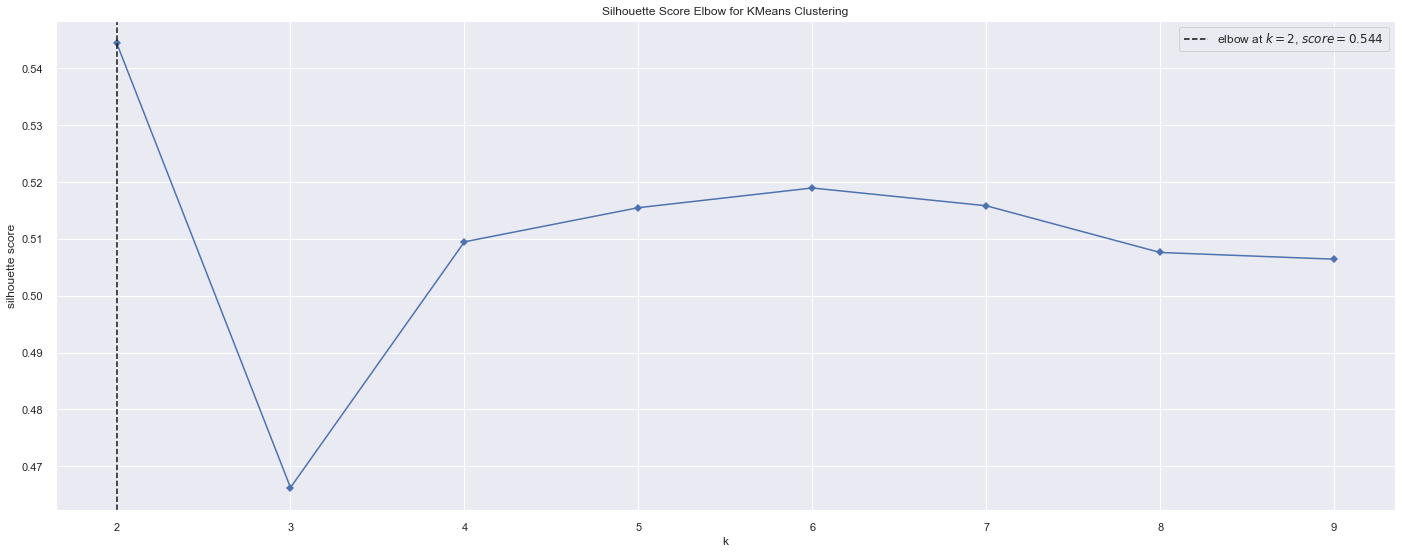

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [30]:
kmeans = KElbowVisualizer(model,k=clusters, metric='silhouette',timings=False,random_state=101)
kmeans.fit(X)
kmeans.show()

### 7.2.1. Silhouette Analysis

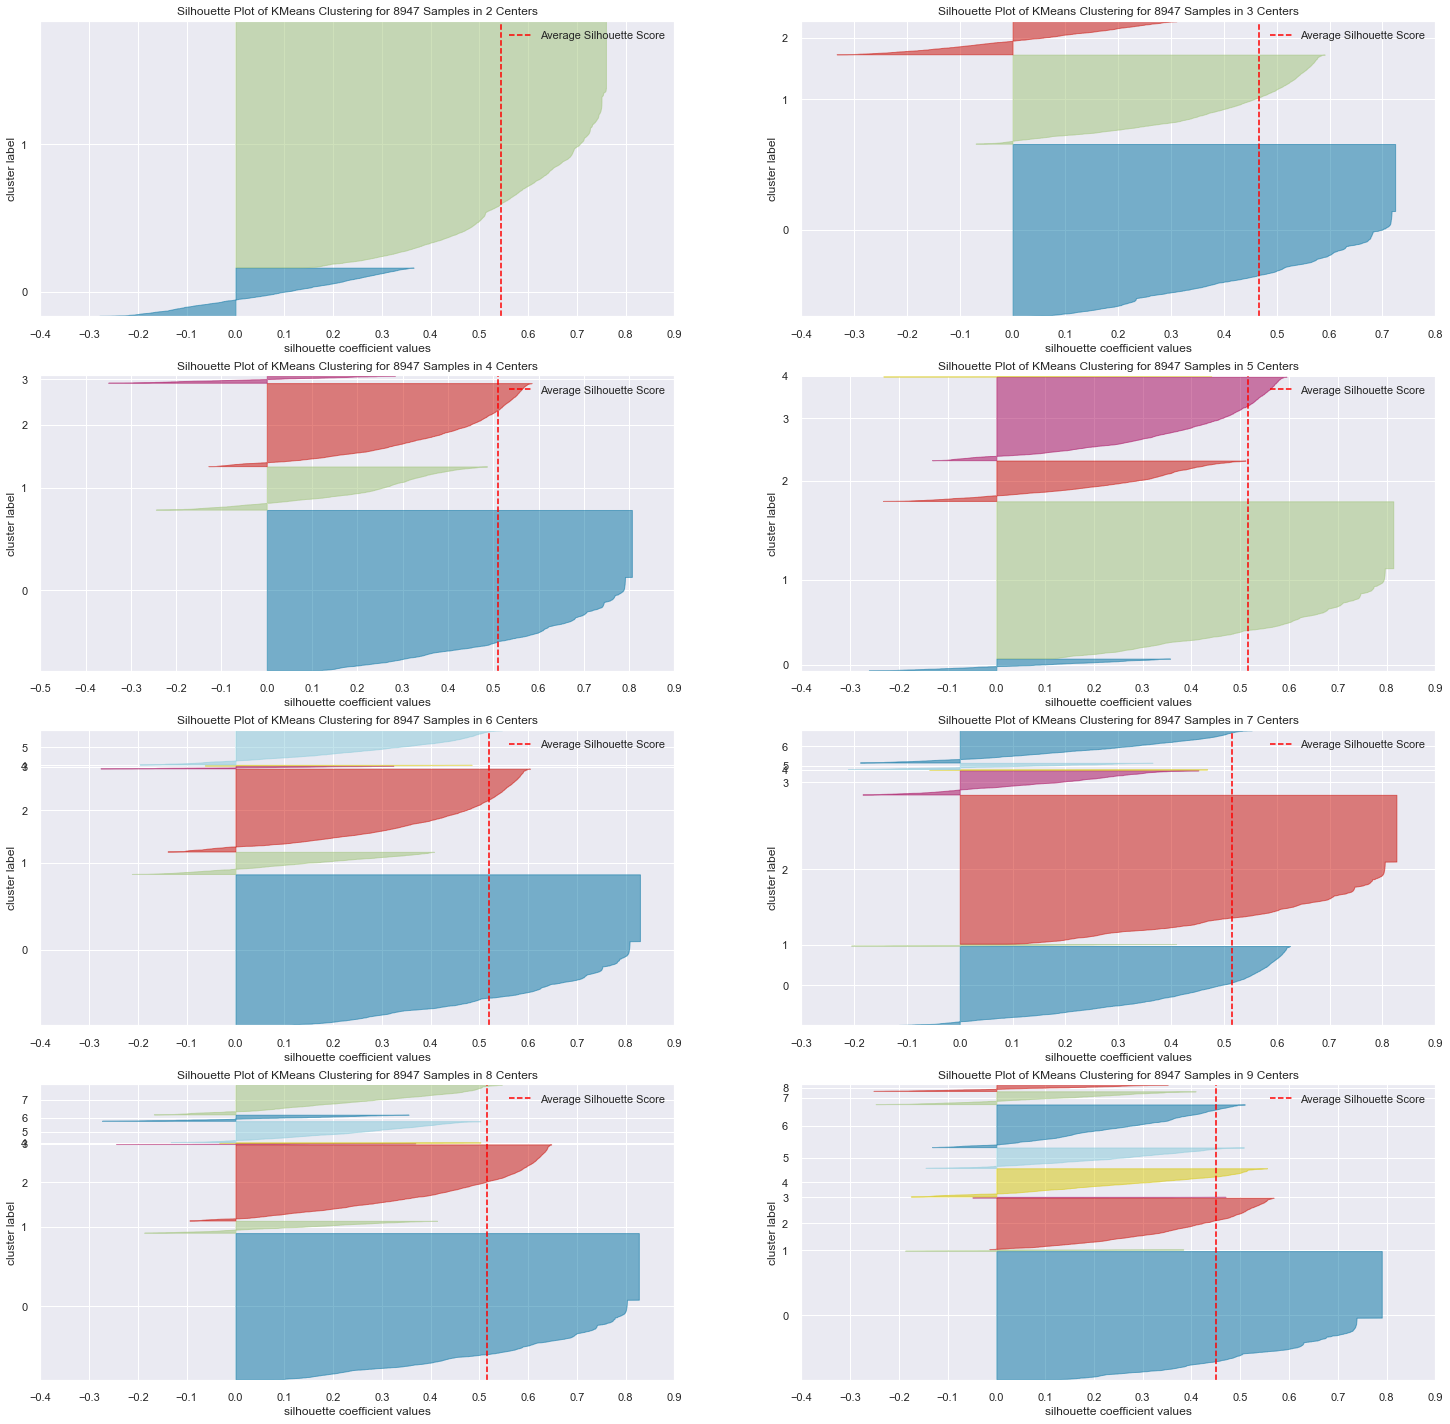

In [31]:
fig, ax = plt.subplots(4,2,figsize=(25,25))

for k in clusters:
  km = KMeans(n_clusters=k,init='random',n_init=10,max_iter=100,random_state=101)
  q, mod = divmod(k,2)

  visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
  visualizer.fit(X)
  visualizer.finalize()

## 7.3. Davies Bouldin Score

In [32]:
davies_list = []

for k in clusters:
  # model definition
  kmeans_model = KMeans(n_clusters=k,random_state=101)

  # model training
  kmeans_model.fit(X)

  # model predict
  labels = kmeans_model.predict(X)

  # model performance
  dav = m.davies_bouldin_score(X, labels)

  davies_list.append(dav)

Text(0, 0.5, 'Davies Boulding Score')

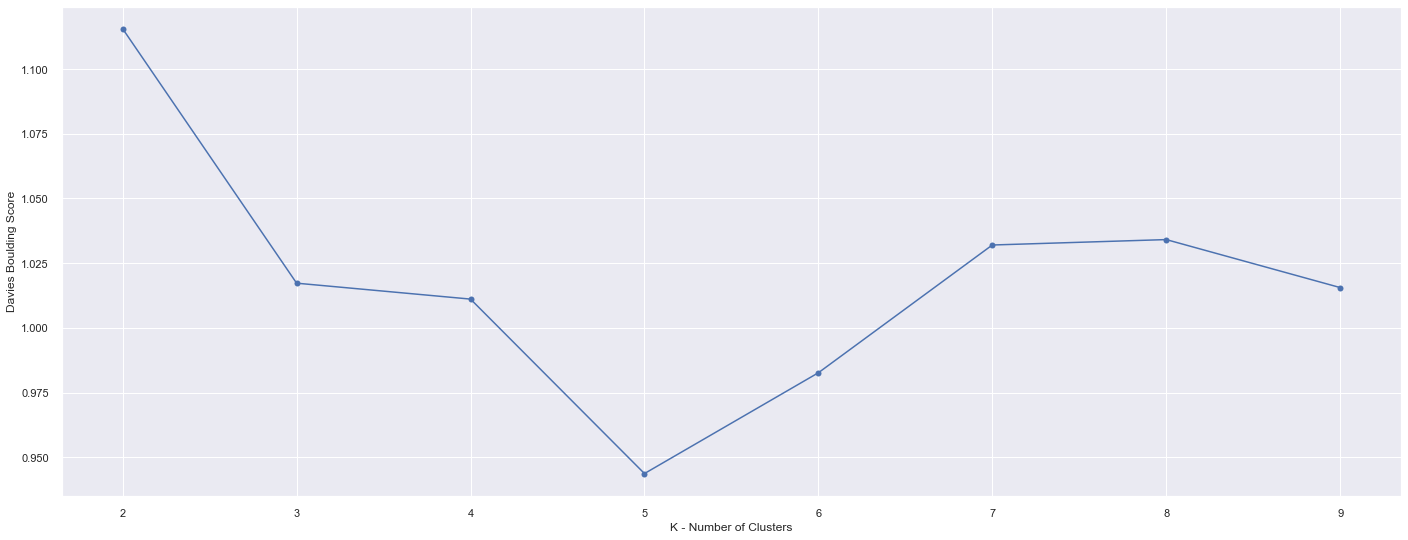

In [33]:
plt.plot(clusters, davies_list,marker='o')
plt.xlabel('K - Number of Clusters')
plt.ylabel('Davies Boulding Score')

# 8. Model Training

## 8.1. K-Means

In [34]:
# Model Definition
k = 6
kmeans = KMeans(init='random',n_clusters=k,random_state=101)

# Model Training
kmeans.fit(X)

# Clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [35]:
# WWS (Within-Cluster Sum of Square)
print('WWS value: {:.2f}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {:.2f}'.format(m.silhouette_score(X,labels)))

# Davies Bouldin Score
print('Davies Boulding Score: {:.2f}'.format(davies_list[1]))

WWS value: 13156.15
SS value: 0.52
Davies Boulding Score: 1.02


# 9. Cluster Analysis

In [36]:
df9 = df3[['cust_id',
           'oneoff_purchases',
           'installments_purchases',
           'oneoff_purchases_frequency',
           'purchases_installments_frequency',
           'purchases_trx']].copy()
df9['cluster'] = labels
df9.head()

,cust_id,oneoff_purchases,installments_purchases,oneoff_purchases_frequency,purchases_installments_frequency,purchases_trx,cluster
0,10001,0.00,95.4,0.000000,0.083333,2,0
1,10002,0.00,0.0,0.000000,0.000000,0,0
2,10003,773.17,0.0,1.000000,0.000000,12,5
3,10004,1499.00,0.0,0.083333,0.000000,1,0
4,10005,16.00,0.0,0.083333,0.000000,1,0


## 9.1. Two-Dimentions Plot

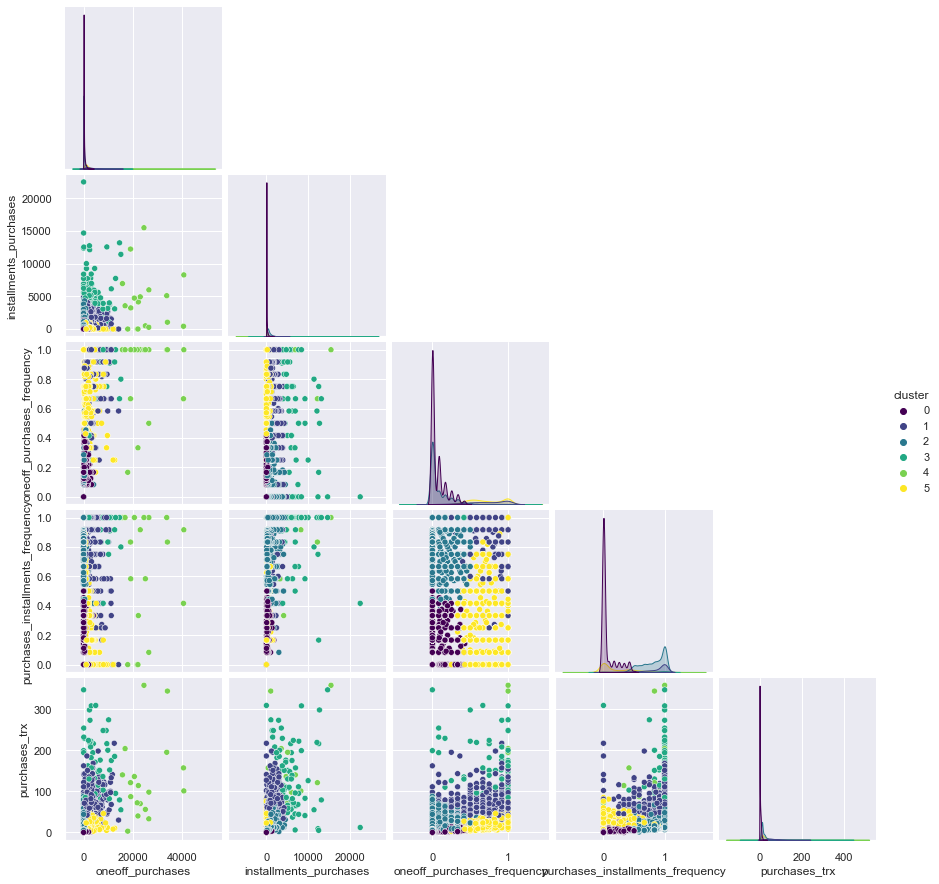

In [37]:
df_viz = df9.drop('cust_id',axis=1)
sns.pairplot(df_viz,hue='cluster',palette='viridis',corner=True)

## 9.2. UMAP

In [ ]:
# Quciker from larger datasets but more difficult to visualize
# Change n_neighbors to see something similar to a local structure (\/) ou global structure (/\)
reducer = umap.UMAP(n_neighbors=25,random_state=101)
embedding = reducer.fit_transform(X)

# Embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# Plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',data=df_viz,hue='cluster',palette='viridis')

## 9.3. t-SNE

## 9.4. Cluster Profile

In [ ]:
df9.columns.tolist()[1:-1]

In [ ]:
df_cluster = df9[['cust_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = round(100*(df_cluster['cust_id']/df_cluster['cust_id'].sum()),2)

for feature in df9.columns.tolist()[1:-1]:
  df_aux = df9[[feature,'cluster']].groupby('cluster').mean().reset_index()
  df_cluster = pd.merge(df_cluster,df_aux, how='inner',on='cluster')

In [ ]:
df_cluster

### Cluster 01 *(High OneOff Customers)*
- Number of Customers: **18** (0.2% of customers)
- Total Paid in Cash: **$25,037**
- Total Paid in Installments: **4,270**
- Frequency of Purchases in Cash (from 0 to 1): **0.85** 
- Frequency of Purchases in Installments (from 0 to 1): **0.63** 
- Amount of Purchases: **129**

### Cluster 02 *(High Installments Customers)*
- Number of Customers: **79** (0.88% of customers)
- Total Paid in Cash: **$4,021**
- Total Paid in Installments: **6,124**
- Frequency of Purchases in Cash (from 0 to 1): **0.61** 
- Frequency of Purchases in Installments (from 0 to 1): **0.90** 
- Amount of Purchases: **136**

### Cluster 03 *(Medium Spenders)*
- Number of Customers: **676** (7.56% of customers)
- Total Paid in Cash: **$2,599**
- Total Paid in Installments: **1,434**
- Frequency of Purchases in Cash (from 0 to 1): **0.71** 
- Frequency of Purchases in Installments (from 0 to 1): **0.87** 
- Amount of Purchases: **64**

### Cluster 04 *(Low OneOff Customers)*
- Number of Customers: **1048** (11.71% of customers)
- Total Paid in Cash: **$1,485**
- Total Paid in Installments: **172**
- Frequency of Purchases in Cash (from 0 to 1): **0.71** 
- Frequency of Purchases in Installments (from 0 to 1): **0.20** 
- Amount of Purchases: **20**

### Cluster 05 *(Low Installments Customers)*
- Number of Customers: **2528** (28.26% of customers)
- Total Paid in Cash: **$180**
- Total Paid in Installments: **686**
- Frequency of Purchases in Cash (from 0 to 1): **0.07** 
- Frequency of Purchases in Installments (from 0 to 1): **0.81** 
- Amount of Purchases: **17**

### Cluster 06 *(Leavers)*
- Number of Customers: **4598** (51.39% of customers)
- Total Paid in Cash: **$165**
- Total Paid in Installments: **50**
- Frequency of Purchases in Cash (from 0 to 1): **0.06** 
- Frequency of Purchases in Installments (from 0 to 1): **0.06** 
- Amount of Purchases: **2**

# 10. Deploy to Production